In [317]:
import numpy as np
import networkx as nx
import pandas as pd
seed = None
rng = np.random.default_rng(seed)

In [326]:
def interaction(i, partner, fitnesses, cheater_flag, tags, tolerance, 
                interactions_attempted, interactions_made):
    interactions_attempted += 1
    if cheater_flag == False and abs(tags[i] - tags[partner]) <= tolerance:
        fitnesses[i] -= cost
        fitnesses[partner] += benefit
        interactions_made += 1
    return fitnesses, interactions_attempted, interactions_made

def reproduction(i, mate, fitnesses, tags, tolerances, cheater_flags):
    fitness = fitnesses[i]
    fitness_mate = fitnesses[mate]

    if fitness > fitness_mate: parent = i
    elif fitness < fitness_mate: parent = mate
    else: parent = rng.choice([i, mate])

    child_tag = tags[parent]
    child_tolerance = tolerances[parent]
    child_cheater_flag = cheater_flags[parent]

    if rng.random() < mutation_rate:
        child_tag = rng.random()
        noise = rng.normal(mu, sigma)
        child_tolerance += noise
        if child_tolerance < min_tolerance: child_tolerance = min_tolerance
        if rng.random() <= cheater_mutation_rate:
            child_cheater_flag = True
        else:
            child_cheater_flag = False
        return child_tag, child_tolerance, child_cheater_flag

    return child_tag, child_tolerance, child_cheater_flag


In [327]:
n = 100 # population size
cost = 1.0
benefit = 10
pairings = 3
mutation_rate = 0.1
min_tolerance = 0
cheater_mutation_rate = 0 #social parasite type, no changes made
n_neighbors = n - 1 # neighbor radius = neighbors / 2, max is n - 1
generations = 1000

mu = 0
sigma = 0.01

In [328]:
output = []

child_tags = rng.uniform(low = 0, high = 1, size = n)
child_tolerances = rng.uniform(low = min_tolerance, high = 1, size = n)
child_cheater_flags = np.zeros(n) 
fitnesses = np.zeros(n)

for g in range(1, generations + 1):

    tags = child_tags.copy()
    tolerances = child_tolerances.copy()
    cheater_flags = child_cheater_flags.copy()
    fitnesses = np.zeros(n)

    interactions_made, interactions_attempted = 0, 0

    G = nx.random_regular_graph(d = n_neighbors, n = n)
    neighbors = [list(nx.all_neighbors(G, i)) for i in range(n)]
    
    for i in range(n):
        for p in range(pairings):
            partner = rng.choice(neighbors[i])
            fitnesses, interactions_attempted, interactions_made = interaction(i, partner, fitnesses, cheater_flags[i], tags, tolerances[i], 
                                                                               interactions_attempted, interactions_made)  
    for i in range(n):
        mate = rng.choice(neighbors[i])
        child_tags[i], child_tolerances[i], child_cheater_flags[i] = reproduction(i, mate, fitnesses, tags, tolerances, cheater_flags)

    output.append([g, interactions_attempted, interactions_made, tags, tolerances, cheater_flags, fitnesses])

output_df = pd.DataFrame(output, columns = ('generation', 'interactions_attempted', 'interactions_made', 'tags', 'tolerances', 
                                            'cheater_flags', 'fitnesses')).explode(['tags', 'tolerances', 'cheater_flags', 'fitnesses'])

In [329]:
directory = './'
simulation_name = '12Feb2024'
output_df.to_csv(directory + simulation_name + '.csv', index=False)

In [330]:
unique_tags = output_df.groupby('generation').tags.nunique()
tolerance = output_df.groupby('generation').tolerances.mean()
output_df['donation_rate'] = output_df['interactions_made']/output_df['interactions_attempted']
results = output_df[['generation', 'donation_rate']].drop_duplicates()
unique_tags.index = results.index
tolerance.index = results.index
results['unique_tags'] = unique_tags / n
results['tolerance'] = tolerance

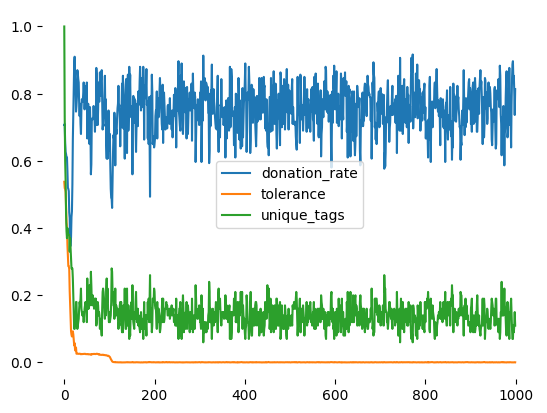

In [331]:
import matplotlib as plt
import seaborn as sns

results[['donation_rate', 'tolerance', 'unique_tags']].plot()
sns.despine(left = True, bottom = True)

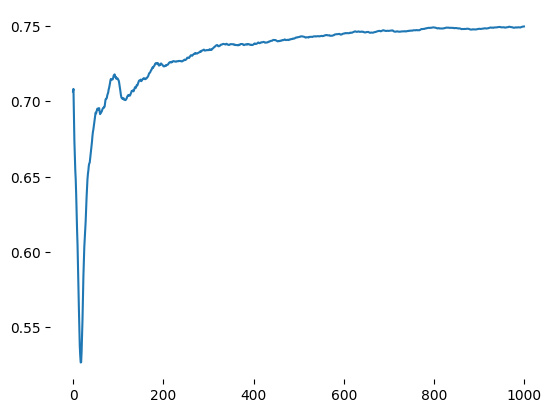

In [332]:
results['donation_rate'].expanding().mean().plot()
sns.despine(left = True, bottom = True)

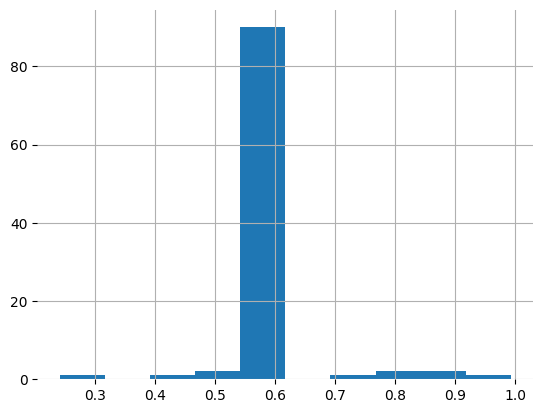

In [333]:
output_df['tags'][output_df['generation'] == max(output_df['generation'])].hist()
sns.despine(left = True, bottom = True)